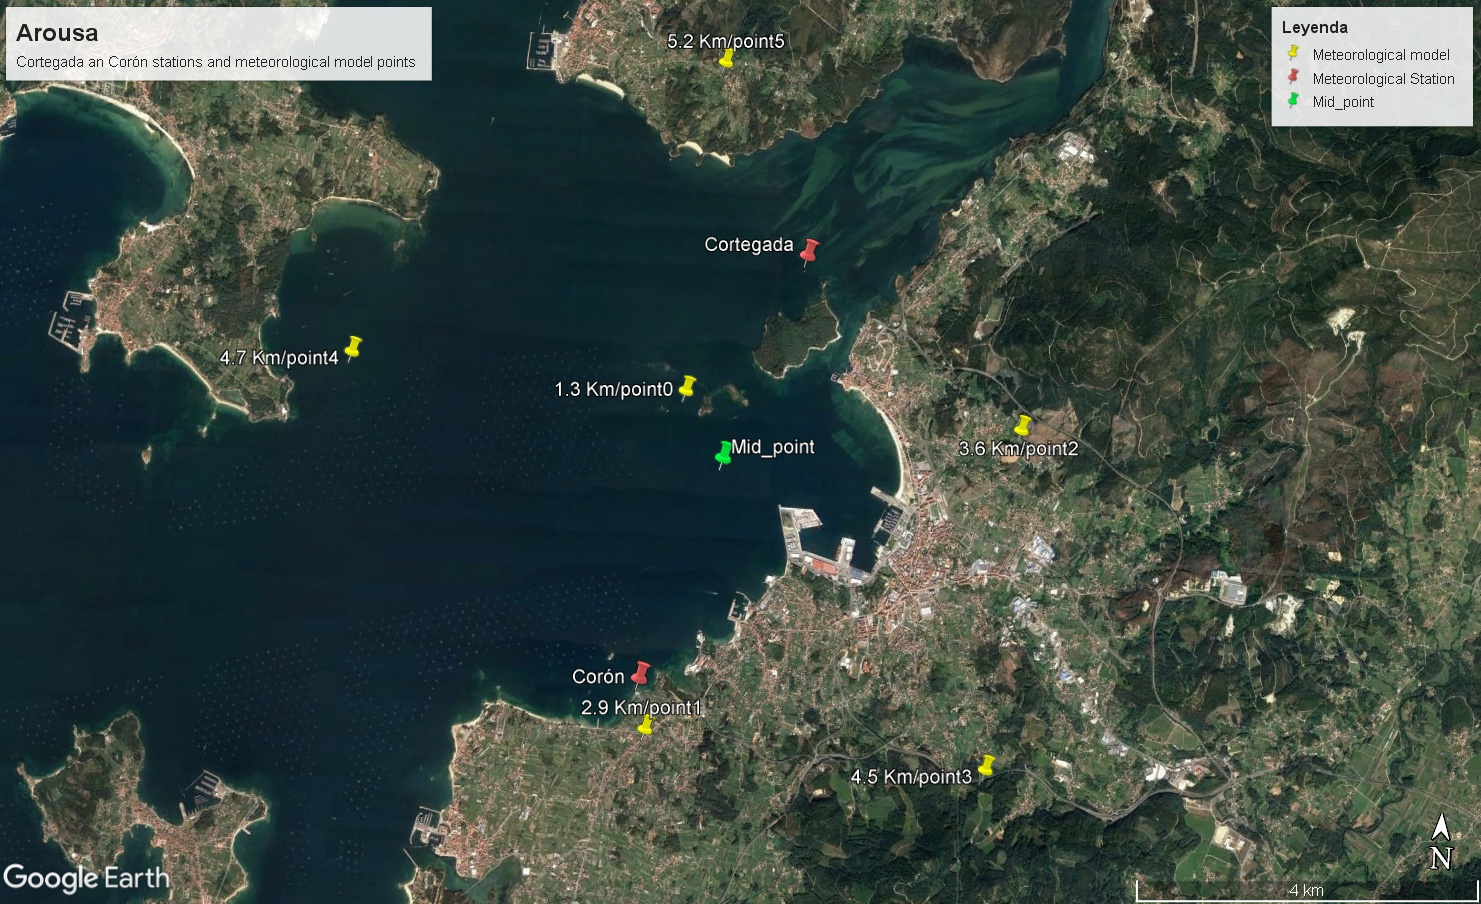

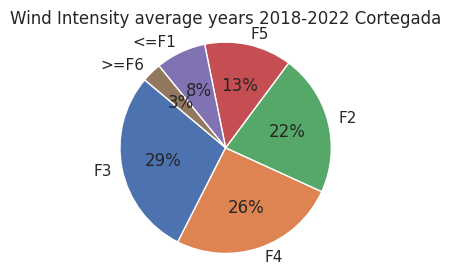

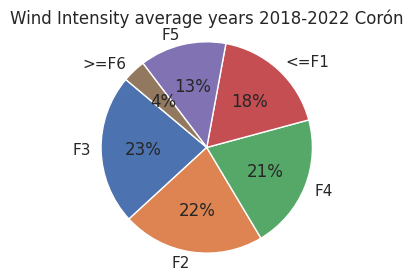

In [ ]:
#@title Wind speed
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.core.arrays import categorical
import seaborn as sns
from scipy.stats import entropy
import math
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_absolute_error
from scipy.stats import entropy

sns.set(style="whitegrid")
#load stations and met model
corte = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Coron/station_data/cortegada.csv",
                    usecols = ["time","spd_o"],parse_dates=["time"]).set_index("time").add_suffix("_corte")
coron = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Coron/station_data/coron.csv",
                    usecols = ["time","spd_o"],parse_dates=["time"]).set_index("time").add_suffix("_coron")
model_d0 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Coron/met_ model/model_vs_Cortegada_Coron/mid_point_lat42.6lon-8.794p6R4KmD0.csv",
                       usecols = ["time","mod0","mod1","mod2","mod3","mod4","mod5","dir0","dir1","wind_gust0","wind_gust1"],
                       parse_dates=["time"]).set_index("time").add_suffix("_d0")
model_d1 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Coron/met_ model/model_vs_Cortegada_Coron/mid_point_lat42.6lon-8.794p6R4KmD1.csv",
                       usecols = ["time","mod0","mod1","mod2","mod3","mod4","mod5","dir0","dir1","wind_gust0","wind_gust1"],
                       parse_dates=["time"]).set_index("time").add_suffix("_d1")

#delete duplicated and resample
corte = corte[~corte.index.duplicated(keep='first')]
corte = corte.resample("H",label="right",closed="right").mean()
coron = coron[~coron.index.duplicated(keep='first')]
coron = coron.resample("H",label="right",closed="right").mean()

#global data frame
df_global = pd.concat([corte,coron,model_d0,model_d1],axis=1).dropna()

#Calculate mae
mae_results = {}
for col1 in df_global.columns:
    for col2 in df_global.columns:
        if col1 != col2:
            mae = mean_absolute_error(df_global[col1], df_global[col2])
            mae_results[f'{col1} vs {col2}'] = mae

df_mae = pd.DataFrame.from_dict(mae_results, orient='index', columns=['MAE'])


#label Beaufort
labels = ["<=F1","F2","F3","F4","F5",">=F6"]
interval = pd.IntervalIndex.from_tuples([(-1, 1.5), (1.5, 3.3),(3.3,5.5),
                                     (5.5,8),(8,10.7),(10.7,60)])
columns_global = df_global.columns
for col in columns_global:
  df_global[col+"_l"] = pd.cut(df_global[col], bins=interval,
                                                    retbins=False,
                                                    labels=labels).map({a:b for a,b in zip(interval,labels)}).astype('category')
df_global = df_global.drop(columns = ['dir0_d0_l','dir1_d0_l','dir0_d1_l','dir1_d1_l','wind_gust0_d0_l','wind_gust1_d0_l','wind_gust0_d1_l',"wind_gust1_d1_l"])
# accuracy calculation
acc_results = {}
columns_s = df_global.select_dtypes(include=['category']).columns
for col1 in df_global[columns_s].columns:
    for col2 in df_global[columns_s].columns:
        if col1 != col2:
            acc = accuracy_score(df_global[columns_s][col1], df_global[columns_s][col2])
            acc_results[f'{col1} vs {col2}'] = acc
df_acc = pd.DataFrame.from_dict(acc_results, orient='index', columns=['Accuracy'])

# climatology coron Cortgada
plt.figure(figsize=(3, 3))
plt.pie(df_global.spd_o_corte_l.value_counts(),labels = df_global.spd_o_corte_l.value_counts().index, autopct='%1.0f%%', startangle=140)
plt.title('Wind Intensity average years 2018-2022 Cortegada')
plt.axis('equal')
plt.show()

plt.figure(figsize=(3, 3))
plt.pie(df_global.spd_o_coron_l.value_counts(),labels = df_global.spd_o_coron_l.value_counts().index, autopct='%1.0f%%', startangle=140)
plt.title('Wind Intensity average years 2018-2022 Corón')
plt.axis('equal')
plt.show()



/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:3544: UserWarning: 5.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:3544: UserWarning: 9.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


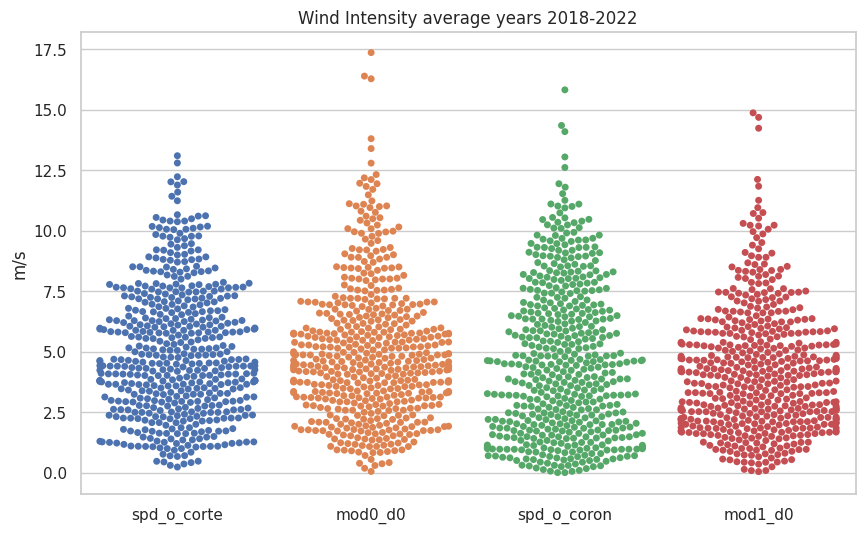

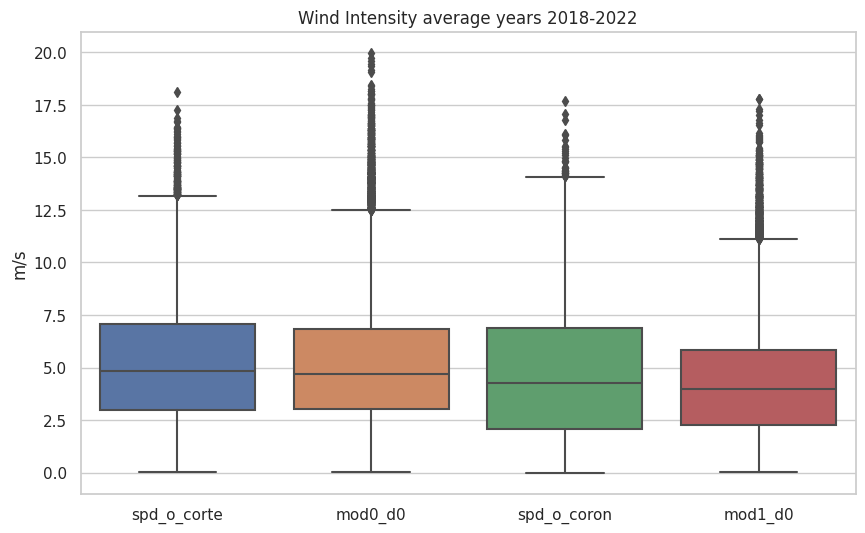

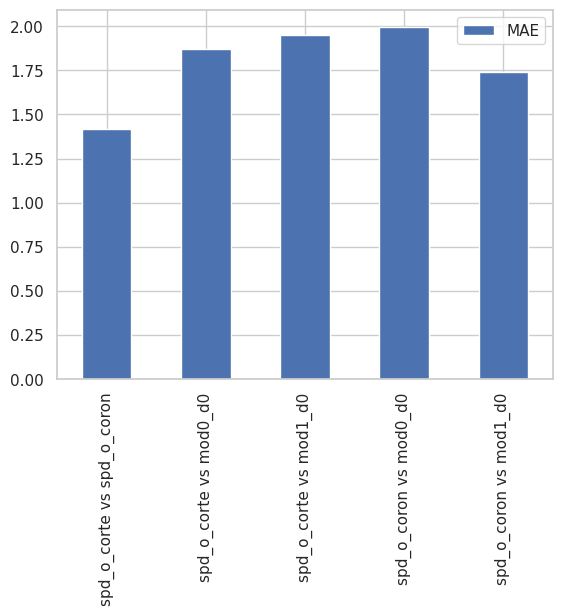

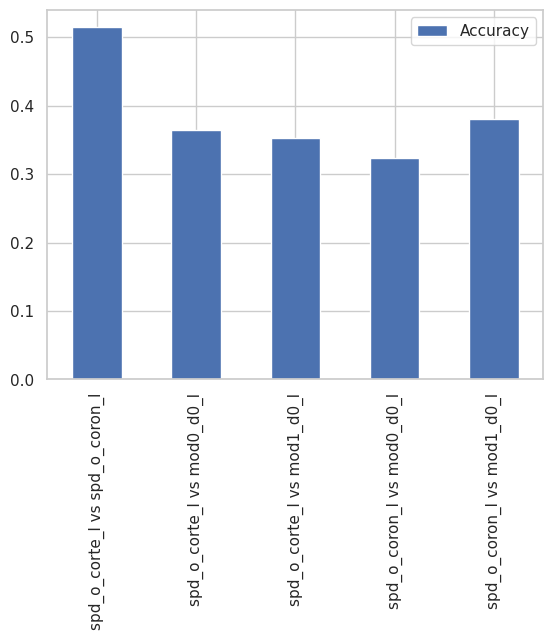

In [ ]:
# @title MAE and Accuracy
# Creating a boxplot chart
plt.figure(figsize=(10, 6))
sns.set(style="whitegrid")
sns.swarmplot(df_global[["spd_o_corte","mod0_d0","spd_o_coron","mod1_d0"]].sample(500))
plt.title('Wind Intensity average years 2018-2022')
plt.ylabel('m/s')
plt.xlabel("")
plt.show()

plt.figure(figsize=(10, 6))
sns.set(style="whitegrid")
sns.boxplot(df_global[["spd_o_corte","mod0_d0","spd_o_coron","mod1_d0"]])
plt.title('Wind Intensity average years 2018-2022')
plt.ylabel('m/s')
plt.xlabel("")
plt.show()



columns_mae = ['spd_o_corte vs spd_o_coron', 'spd_o_corte vs mod0_d0',
       'spd_o_corte vs mod1_d0','spd_o_coron vs mod0_d0',
       'spd_o_coron vs mod1_d0']
columns_acc = ['spd_o_corte_l vs spd_o_coron_l', 'spd_o_corte_l vs mod0_d0_l',
       'spd_o_corte_l vs mod1_d0_l','spd_o_coron_l vs mod0_d0_l',
       'spd_o_coron_l vs mod1_d0_l']
df_mae.loc[columns_mae].plot(kind="bar");
df_acc.loc[columns_acc].plot(kind="bar");

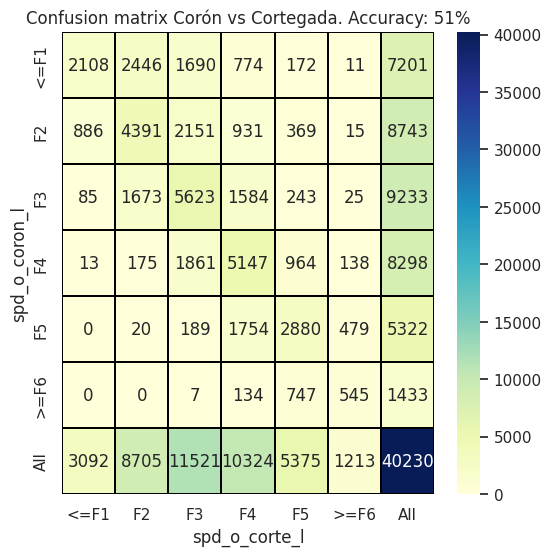

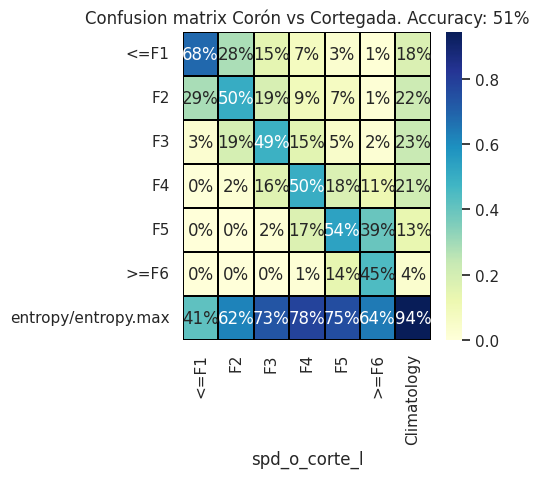

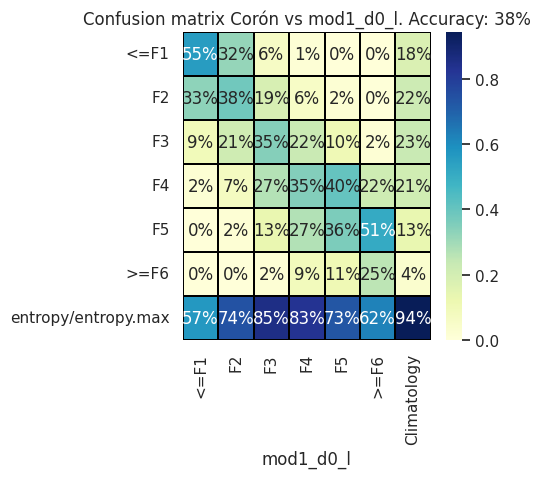

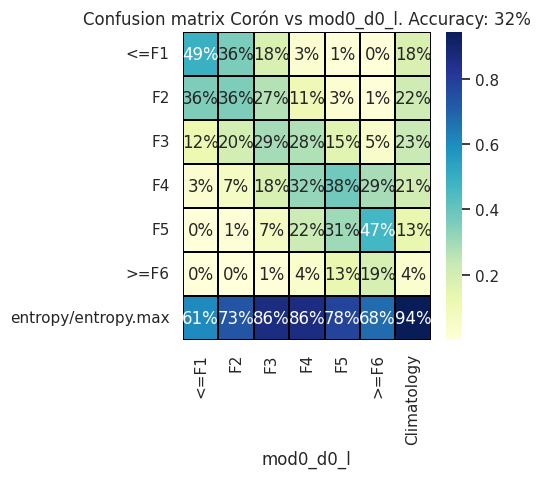

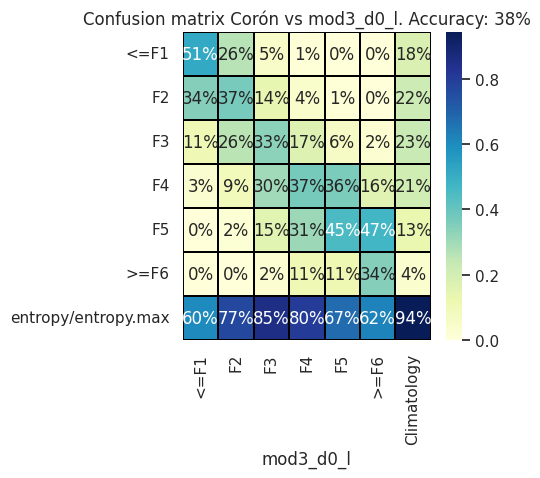

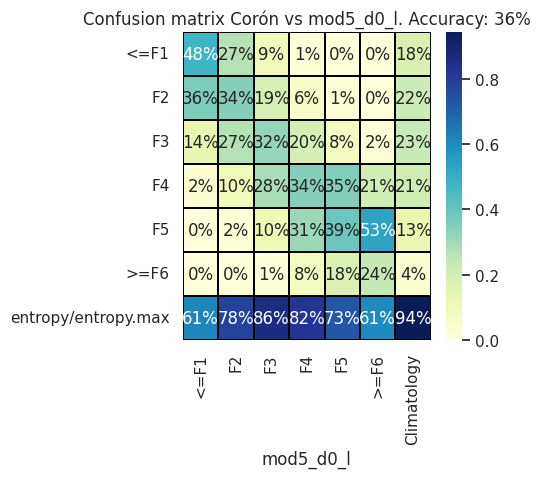

In [ ]:
# @title Confusion matrix Corón meteorological model points forecast day0 and Cortegada same time

# raw numbers
plt.figure(figsize=(6, 6))
acc = df_acc.loc[["spd_o_corte_l vs spd_o_coron_l"]].values[0][0]
plt.title("Confusion matrix Corón vs Cortegada. Accuracy: {:.0%}".format(acc))
global_sc = pd.crosstab(df_global.spd_o_coron_l, df_global.spd_o_corte_l,margins=True,)
sns.heatmap(global_sc,annot=True,cmap="YlGnBu",fmt='.0f',linewidths=.3, linecolor='black');

# % numbers
plt.figure(figsize=(4, 4))
acc = df_acc.loc[["spd_o_corte_l vs spd_o_coron_l"]].values[0][0]
plt.title("Confusion matrix Corón vs Cortegada. Accuracy: {:.0%}".format(acc))
column_sc = pd.crosstab(df_global.spd_o_coron_l, df_global.spd_o_corte_l, margins=True,normalize="columns")
entro = pd.DataFrame(entropy(column_sc,base=2)/(math.log2(column_sc.shape[0])),columns=["entropy/entropy.max"],
                    index=column_sc.columns).T
entropic_sc = pd.concat([column_sc,entro]).rename(columns={"All":"Climatology"})
sns.heatmap(entropic_sc,annot=True,cmap="YlGnBu",fmt='.0%',linewidths=.3, linecolor='black');

# % numbers
plt.figure(figsize=(4, 4))
acc = df_acc.loc[["mod1_d0_l vs spd_o_coron_l"]].values[0][0]
plt.title("Confusion matrix Corón vs mod1_d0_l. Accuracy: {:.0%}".format(acc))
column_sc = pd.crosstab(df_global.spd_o_coron_l, df_global.mod1_d0_l, margins=True,normalize="columns")
entro = pd.DataFrame(entropy(column_sc,base=2)/(math.log2(column_sc.shape[0])),columns=["entropy/entropy.max"],
                    index=column_sc.columns).T
entropic_sc = pd.concat([column_sc,entro]).rename(columns={"All":"Climatology"})
sns.heatmap(entropic_sc,annot=True,cmap="YlGnBu",fmt='.0%',linewidths=.3, linecolor='black');


# % numbers
plt.figure(figsize=(4, 4))
acc = df_acc.loc[["mod0_d0_l vs spd_o_coron_l"]].values[0][0]
plt.title("Confusion matrix Corón vs mod0_d0_l. Accuracy: {:.0%}".format(acc))
column_sc = pd.crosstab(df_global.spd_o_coron_l, df_global.mod0_d0_l, margins=True,normalize="columns")
entro = pd.DataFrame(entropy(column_sc,base=2)/(math.log2(column_sc.shape[0])),columns=["entropy/entropy.max"],
                    index=column_sc.columns).T
entropic_sc = pd.concat([column_sc,entro]).rename(columns={"All":"Climatology"})
sns.heatmap(entropic_sc,annot=True,cmap="YlGnBu",fmt='.0%',linewidths=.3, linecolor='black');


# % numbers
plt.figure(figsize=(4, 4))
acc = df_acc.loc[["mod3_d0_l vs spd_o_coron_l"]].values[0][0]
plt.title("Confusion matrix Corón vs mod3_d0_l. Accuracy: {:.0%}".format(acc))
column_sc = pd.crosstab(df_global.spd_o_coron_l, df_global.mod3_d0_l, margins=True,normalize="columns")
entro = pd.DataFrame(entropy(column_sc,base=2)/(math.log2(column_sc.shape[0])),columns=["entropy/entropy.max"],
                    index=column_sc.columns).T
entropic_sc = pd.concat([column_sc,entro]).rename(columns={"All":"Climatology"})
sns.heatmap(entropic_sc,annot=True,cmap="YlGnBu",fmt='.0%',linewidths=.3, linecolor='black');


# % numbers
plt.figure(figsize=(4, 4))
acc = df_acc.loc[["mod5_d0_l vs spd_o_coron_l"]].values[0][0]
plt.title("Confusion matrix Corón vs mod5_d0_l. Accuracy: {:.0%}".format(acc))
column_sc = pd.crosstab(df_global.spd_o_coron_l, df_global.mod5_d0_l, margins=True,normalize="columns")
entro = pd.DataFrame(entropy(column_sc,base=2)/(math.log2(column_sc.shape[0])),columns=["entropy/entropy.max"],
                    index=column_sc.columns).T
entropic_sc = pd.concat([column_sc,entro]).rename(columns={"All":"Climatology"})
sns.heatmap(entropic_sc,annot=True,cmap="YlGnBu",fmt='.0%',linewidths=.3, linecolor='black');



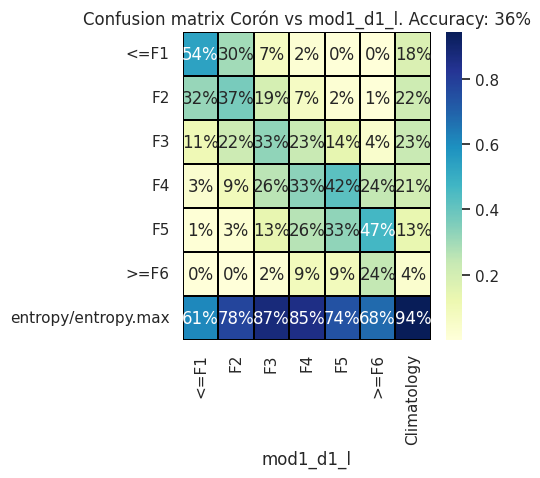

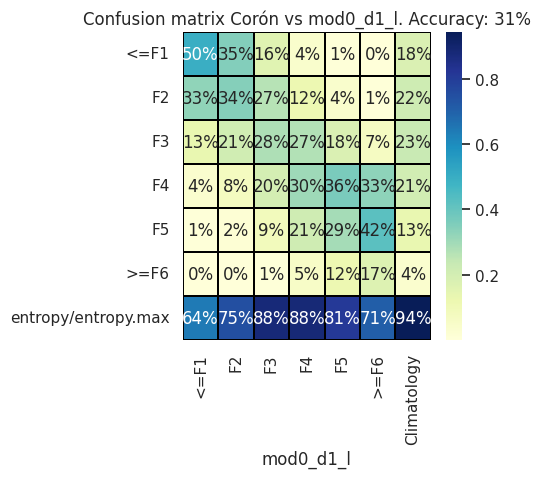

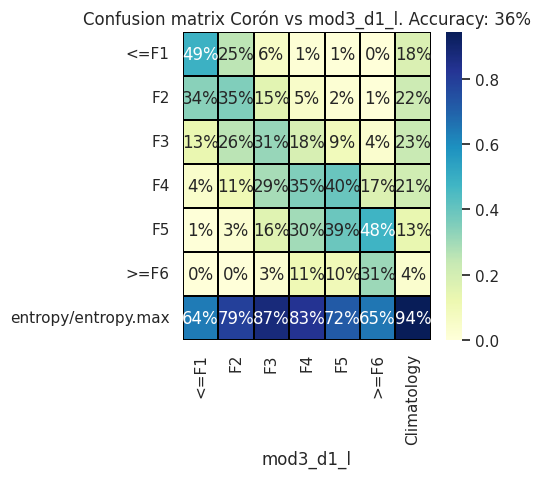

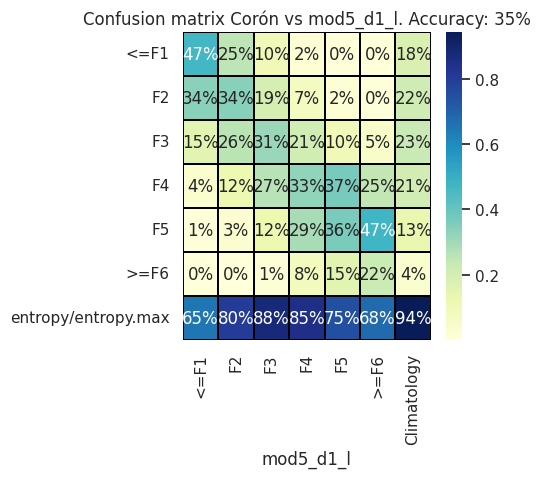

In [ ]:
# @title Confusion matrix Corón meteorological model points forecast day1


# % numbers
plt.figure(figsize=(4, 4))
acc = df_acc.loc[["mod1_d1_l vs spd_o_coron_l"]].values[0][0]
plt.title("Confusion matrix Corón vs mod1_d1_l. Accuracy: {:.0%}".format(acc))
column_sc = pd.crosstab(df_global.spd_o_coron_l, df_global.mod1_d1_l, margins=True,normalize="columns")
entro = pd.DataFrame(entropy(column_sc,base=2)/(math.log2(column_sc.shape[0])),columns=["entropy/entropy.max"],
                    index=column_sc.columns).T
entropic_sc = pd.concat([column_sc,entro]).rename(columns={"All":"Climatology"})
sns.heatmap(entropic_sc,annot=True,cmap="YlGnBu",fmt='.0%',linewidths=.3, linecolor='black');


# % numbers
plt.figure(figsize=(4, 4))
acc = df_acc.loc[["mod0_d1_l vs spd_o_coron_l"]].values[0][0]
plt.title("Confusion matrix Corón vs mod0_d1_l. Accuracy: {:.0%}".format(acc))
column_sc = pd.crosstab(df_global.spd_o_coron_l, df_global.mod0_d1_l, margins=True,normalize="columns")
entro = pd.DataFrame(entropy(column_sc,base=2)/(math.log2(column_sc.shape[0])),columns=["entropy/entropy.max"],
                    index=column_sc.columns).T
entropic_sc = pd.concat([column_sc,entro]).rename(columns={"All":"Climatology"})
sns.heatmap(entropic_sc,annot=True,cmap="YlGnBu",fmt='.0%',linewidths=.3, linecolor='black');


# % numbers
plt.figure(figsize=(4, 4))
acc = df_acc.loc[["mod3_d1_l vs spd_o_coron_l"]].values[0][0]
plt.title("Confusion matrix Corón vs mod3_d1_l. Accuracy: {:.0%}".format(acc))
column_sc = pd.crosstab(df_global.spd_o_coron_l, df_global.mod3_d1_l, margins=True,normalize="columns")
entro = pd.DataFrame(entropy(column_sc,base=2)/(math.log2(column_sc.shape[0])),columns=["entropy/entropy.max"],
                    index=column_sc.columns).T
entropic_sc = pd.concat([column_sc,entro]).rename(columns={"All":"Climatology"})
sns.heatmap(entropic_sc,annot=True,cmap="YlGnBu",fmt='.0%',linewidths=.3, linecolor='black');


# % numbers
plt.figure(figsize=(4, 4))
acc = df_acc.loc[["mod5_d1_l vs spd_o_coron_l"]].values[0][0]
plt.title("Confusion matrix Corón vs mod5_d1_l. Accuracy: {:.0%}".format(acc))
column_sc = pd.crosstab(df_global.spd_o_coron_l, df_global.mod5_d1_l, margins=True,normalize="columns")
entro = pd.DataFrame(entropy(column_sc,base=2)/(math.log2(column_sc.shape[0])),columns=["entropy/entropy.max"],
                    index=column_sc.columns).T
entropic_sc = pd.concat([column_sc,entro]).rename(columns={"All":"Climatology"})
sns.heatmap(entropic_sc,annot=True,cmap="YlGnBu",fmt='.0%',linewidths=.3, linecolor='black');

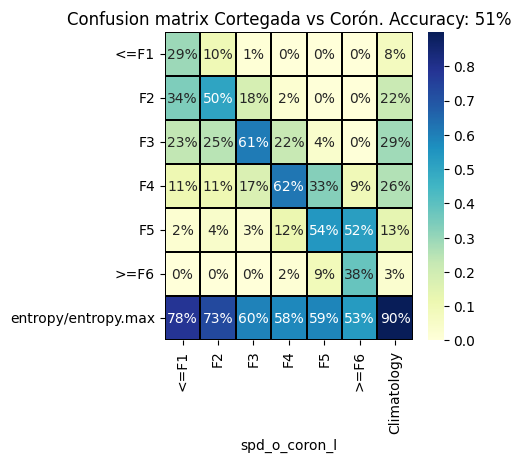

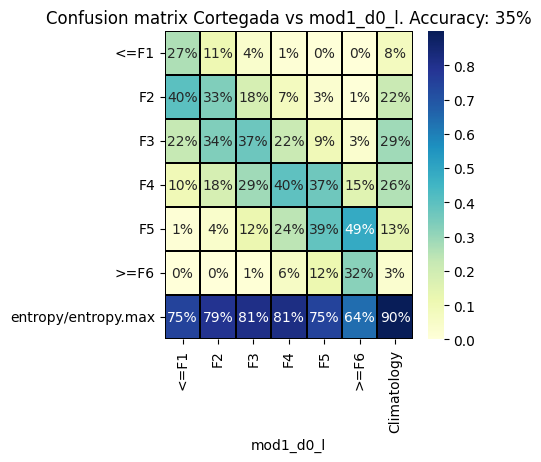

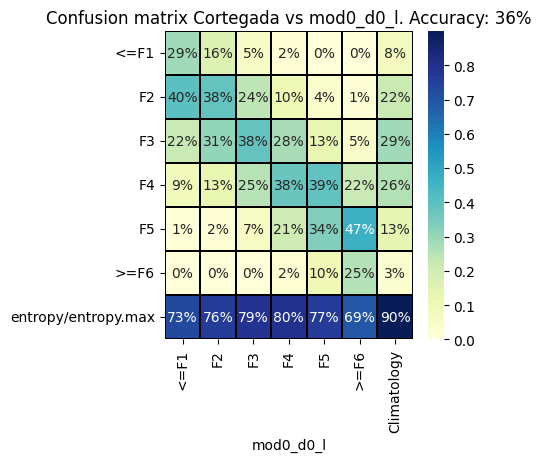

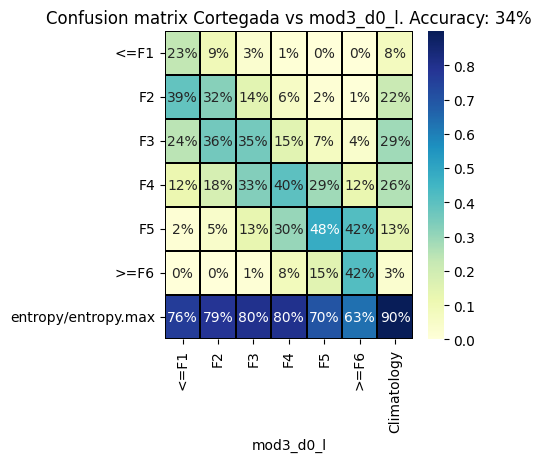

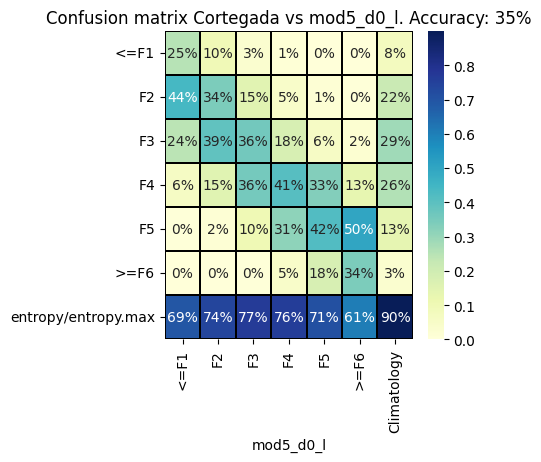

In [ ]:
# @title Confusion matrix Cortegada meteorological model points forecast day0 and Coron same time

# raw numbers
#plt.figure(figsize=(6, 6))
acc = df_acc.loc[["spd_o_corte_l vs spd_o_coron_l"]].values[0][0]
#plt.title("Confusion matrix Corón vs Cortegada. Accuracy: {:.0%}".format(acc))
global_sc = pd.crosstab(df_global.spd_o_corte_l, df_global.spd_o_coron_l,margins=True,)
#sns.heatmap(global_sc,annot=True,cmap="YlGnBu",fmt='.0f',linewidths=.3, linecolor='black');

# % numbers
plt.figure(figsize=(4, 4))
acc = df_acc.loc[["spd_o_coron_l vs spd_o_corte_l"]].values[0][0]
plt.title("Confusion matrix Cortegada vs Corón. Accuracy: {:.0%}".format(acc))
column_sc = pd.crosstab(df_global.spd_o_corte_l, df_global.spd_o_coron_l, margins=True,normalize="columns")
entro = pd.DataFrame(entropy(column_sc,base=2)/(math.log2(column_sc.shape[0])),columns=["entropy/entropy.max"],
                    index=column_sc.columns).T
entropic_sc = pd.concat([column_sc,entro]).rename(columns={"All":"Climatology"})
sns.heatmap(entropic_sc,annot=True,cmap="YlGnBu",fmt='.0%',linewidths=.3, linecolor='black');

# % numbers
plt.figure(figsize=(4, 4))
acc = df_acc.loc[["mod1_d0_l vs spd_o_corte_l"]].values[0][0]
plt.title("Confusion matrix Cortegada vs mod1_d0_l. Accuracy: {:.0%}".format(acc))
column_sc = pd.crosstab(df_global.spd_o_corte_l, df_global.mod1_d0_l, margins=True,normalize="columns")
entro = pd.DataFrame(entropy(column_sc,base=2)/(math.log2(column_sc.shape[0])),columns=["entropy/entropy.max"],
                    index=column_sc.columns).T
entropic_sc = pd.concat([column_sc,entro]).rename(columns={"All":"Climatology"})
sns.heatmap(entropic_sc,annot=True,cmap="YlGnBu",fmt='.0%',linewidths=.3, linecolor='black');


# % numbers
plt.figure(figsize=(4, 4))
acc = df_acc.loc[["mod0_d0_l vs spd_o_corte_l"]].values[0][0]
plt.title("Confusion matrix Cortegada vs mod0_d0_l. Accuracy: {:.0%}".format(acc))
column_sc = pd.crosstab(df_global.spd_o_corte_l, df_global.mod0_d0_l, margins=True,normalize="columns")
entro = pd.DataFrame(entropy(column_sc,base=2)/(math.log2(column_sc.shape[0])),columns=["entropy/entropy.max"],
                    index=column_sc.columns).T
entropic_sc = pd.concat([column_sc,entro]).rename(columns={"All":"Climatology"})
sns.heatmap(entropic_sc,annot=True,cmap="YlGnBu",fmt='.0%',linewidths=.3, linecolor='black');


# % numbers
plt.figure(figsize=(4, 4))
acc = df_acc.loc[["mod3_d0_l vs spd_o_corte_l"]].values[0][0]
plt.title("Confusion matrix Cortegada vs mod3_d0_l. Accuracy: {:.0%}".format(acc))
column_sc = pd.crosstab(df_global.spd_o_corte_l, df_global.mod3_d0_l, margins=True,normalize="columns")
entro = pd.DataFrame(entropy(column_sc,base=2)/(math.log2(column_sc.shape[0])),columns=["entropy/entropy.max"],
                    index=column_sc.columns).T
entropic_sc = pd.concat([column_sc,entro]).rename(columns={"All":"Climatology"})
sns.heatmap(entropic_sc,annot=True,cmap="YlGnBu",fmt='.0%',linewidths=.3, linecolor='black');


# % numbers
plt.figure(figsize=(4, 4))
acc = df_acc.loc[["mod5_d0_l vs spd_o_corte_l"]].values[0][0]
plt.title("Confusion matrix Cortegada vs mod5_d0_l. Accuracy: {:.0%}".format(acc))
column_sc = pd.crosstab(df_global.spd_o_corte_l, df_global.mod5_d0_l, margins=True,normalize="columns")
entro = pd.DataFrame(entropy(column_sc,base=2)/(math.log2(column_sc.shape[0])),columns=["entropy/entropy.max"],
                    index=column_sc.columns).T
entropic_sc = pd.concat([column_sc,entro]).rename(columns={"All":"Climatology"})
sns.heatmap(entropic_sc,annot=True,cmap="YlGnBu",fmt='.0%',linewidths=.3, linecolor='black');

machine learning number: 0
Accuracy: 0.56


Feature  Importance (%)
11  dayofyear            11.8
3     dir1_d0             9.6
1     dir0_d0             9.4
6     mod4_d0             8.9
4     mod2_d0             8.7

machine learning number: 1
Accuracy: 0.56


Feature  Importance (%)
11  dayofyear            11.9
1     dir0_d0             9.8
3     dir1_d0             9.4
6     mod4_d0             9.0
4     mod2_d0             8.6

machine learning number: 2
Accuracy: 0.55


Feature  Importance (%)
11  dayofyear            12.0
1     dir0_d0             9.8
3     dir1_d0             9.4
6     mod4_d0             9.0
4     mod2_d0             8.6

machine learning number: 3
Accuracy: 0.55


Feature  Importance (%)
11  dayofyear            11.7
1     dir0_d0             9.7
3     dir1_d0             9.5
6     mod4_d0             9.0
4     mod2_d0             8.6

machine learning number: 4
Accuracy: 0.57


Feature  Importance (%)
11  dayofyear            12.1
1     dir0_d0             9.9
3     dir1_d0             9.7
6     mod4_d0             8.9
4     mod2_d0             8.7

machine learning number: 5
Accuracy: 0.56


Feature  Importance (%)
11  dayofyear            11.6
1     dir0_d0             9.8
3     dir1_d0             9.5
4     mod2_d0             8.9
6     mod4_d0             8.8

machine learning number: 6
Accuracy: 0.56


Feature  Importance (%)
11  dayofyear            11.8
1     dir0_d0            10.1
3     dir1_d0             9.6
6     mod4_d0             9.1
4     mod2_d0             8.6

machine learning number: 7
Accuracy: 0.57


Feature  Importance (%)
11  dayofyear            12.1
1     dir0_d0             9.7
3     dir1_d0             9.6
6     mod4_d0             9.1
4     mod2_d0             8.6

machine learning number: 8
Accuracy: 0.56


Feature  Importance (%)
11  dayofyear            11.4
3     dir1_d0             9.9
1     dir0_d0             9.7
6     mod4_d0             9.0
4     mod2_d0             8.8

machine learning number: 9
Accuracy: 0.56


Feature  Importance (%)
11  dayofyear            11.8
1     dir0_d0             9.7
3     dir1_d0             9.5
6     mod4_d0             9.2
4     mod2_d0             8.7

Accuracy Machine learning models Corón


acc_t
count  10.000000
mean    0.560000
std     0.006667
min     0.550000
25%     0.560000
50%     0.560000
75%     0.560000
max     0.570000

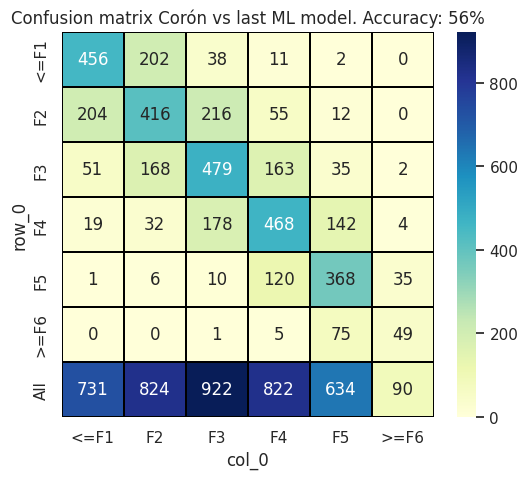

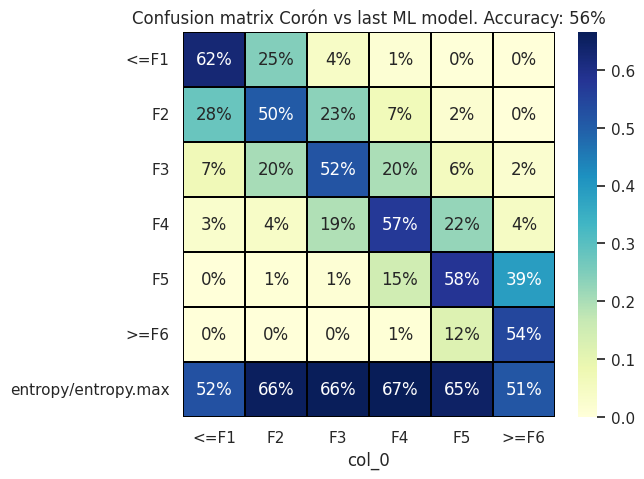

In [ ]:
#@title LGBMClassifier. Forecast Corón (day0)

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from lightgbm.sklearn import LGBMClassifier
from sklearn.model_selection import train_test_split

df_global["hour"] = df_global.index.hour
df_global["month"] = df_global.index.month
df_global["dayofyear"] = df_global.index.dayofyear
df_global["weekofyear"] = df_global.index.isocalendar().week.astype(int)

#numpy randomseed
np.random.seed(1)

# target variable Coron
Y = df_global.spd_o_coron_l
X = df_global[["mod0_d0","dir0_d0","mod1_d0","dir1_d0","mod2_d0","mod3_d0","mod4_d0",
              "wind_gust0_d0","wind_gust1_d0","hour","month",
               "dayofyear","weekofyear"]]

acc_t = []
for t in range (0,10):
  print("machine learning number:",t)
  X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size=0.1, )
  ml_model = LGBMClassifier(n_estimators=200,verbosity=0,force_col_wise=True).fit(X_train,y_train)
  #ml_model = ExtraTreesClassifier(n_estimators=200).fit(X_train,y_train)
  y_pred = ml_model.predict(X_test)
  acc = round(accuracy_score(y_test,y_pred),2)
  print("Accuracy:",acc )
  acc_t.append(acc)


  # Calculate the total sum of importances
  feature_importances = ml_model.feature_importances_
  total_importance = sum(feature_importances)
  importance_percentages = [(importance / total_importance) * 100 for importance in feature_importances]
  feature_names = X.columns
  feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance (%)': np.round(np.array(importance_percentages),decimals=1)})
  feature_importance_df = feature_importance_df.sort_values(by='Importance (%)', ascending=False)
  display(feature_importance_df[0:5])



print("Accuracy Machine learning models Corón")
df_r=pd.DataFrame({"acc_t":acc_t,});
display(df_r.describe())

#last model Confusion matrix
#raw numbers
plt.figure(figsize=(6, 5))
acc = df_r[-1:].values[0][0]
plt.title("Confusion matrix Corón vs last ML model. Accuracy: {:.0%}".format(acc))
column_sc = pd.crosstab(y_test.values,y_pred , margins=True)[labels]
sns.heatmap(column_sc,annot=True,cmap="YlGnBu",fmt='.0f',linewidths=.3, linecolor='black')

# % numbers
plt.figure(figsize=(6, 5))
acc = df_r[-1:].values[0][0]
plt.title("Confusion matrix Corón vs last ML model. Accuracy: {:.0%}".format(acc))
column_sc = pd.crosstab(y_test.values,y_pred , margins=True,normalize="columns")[labels]
entro = pd.DataFrame(entropy(column_sc,base=2)/(math.log2(column_sc.shape[0])),columns=["entropy/entropy.max"],
                    index=column_sc.columns).T
entropic_sc = pd.concat([column_sc,entro]).rename(columns={"All":"Climatology"})
sns.heatmap(entropic_sc,annot=True,cmap="YlGnBu",fmt='.0%',linewidths=.3, linecolor='black');



machine learning number: 0
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004934 seconds.
You can set `force_col_wise=true` to remove the overhead.
Accuracy: 0.62


Feature  Importance (%)
12  dayofyear            10.4
4     dir1_d0             9.0
2     dir0_d0             8.8
7     mod4_d0             8.8
5     mod2_d0             8.3

machine learning number: 1
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005431 seconds.
You can set `force_col_wise=true` to remove the overhead.
Accuracy: 0.64


Feature  Importance (%)
12  dayofyear            10.6
2     dir0_d0             9.3
4     dir1_d0             9.2
7     mod4_d0             8.7
5     mod2_d0             8.1

machine learning number: 2
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008404 seconds.
You can set `force_col_wise=true` to remove the overhead.
Accuracy: 0.61


Feature  Importance (%)
12  dayofyear            10.7
2     dir0_d0             9.3
4     dir1_d0             9.1
7     mod4_d0             8.8
5     mod2_d0             8.3

machine learning number: 3
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001626 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
Accuracy: 0.63


Feature  Importance (%)
12  dayofyear            10.7
2     dir0_d0             9.3
4     dir1_d0             9.2
7     mod4_d0             8.8
5     mod2_d0             7.9

machine learning number: 4
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005138 seconds.
You can set `force_col_wise=true` to remove the overhead.
Accuracy: 0.64


Feature  Importance (%)
12  dayofyear            11.0
2     dir0_d0             9.0
4     dir1_d0             8.8
7     mod4_d0             8.8
5     mod2_d0             8.4

machine learning number: 5
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009435 seconds.
You can set `force_col_wise=true` to remove the overhead.
Accuracy: 0.64


Feature  Importance (%)
12  dayofyear            11.0
4     dir1_d0             9.3
2     dir0_d0             8.9
7     mod4_d0             8.6
5     mod2_d0             8.2

machine learning number: 6
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004918 seconds.
You can set `force_col_wise=true` to remove the overhead.
Accuracy: 0.63


Feature  Importance (%)
12  dayofyear            10.4
2     dir0_d0             9.1
4     dir1_d0             9.1
7     mod4_d0             8.6
5     mod2_d0             8.2

machine learning number: 7
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001538 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
Accuracy: 0.64


Feature  Importance (%)
12  dayofyear            10.7
2     dir0_d0             9.6
4     dir1_d0             9.1
7     mod4_d0             8.7
5     mod2_d0             8.2

machine learning number: 8
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005260 seconds.
You can set `force_col_wise=true` to remove the overhead.
Accuracy: 0.62


Feature  Importance (%)
12  dayofyear            10.3
2     dir0_d0             9.0
4     dir1_d0             9.0
7     mod4_d0             8.9
5     mod2_d0             8.2

machine learning number: 9
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001597 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
Accuracy: 0.63


Feature  Importance (%)
12  dayofyear            10.6
4     dir1_d0             9.2
2     dir0_d0             9.0
7     mod4_d0             9.0
5     mod2_d0             8.0

Accuracy Machine learning models Corón


acc_t
count  10.000000
mean    0.630000
std     0.010541
min     0.610000
25%     0.622500
50%     0.630000
75%     0.640000
max     0.640000

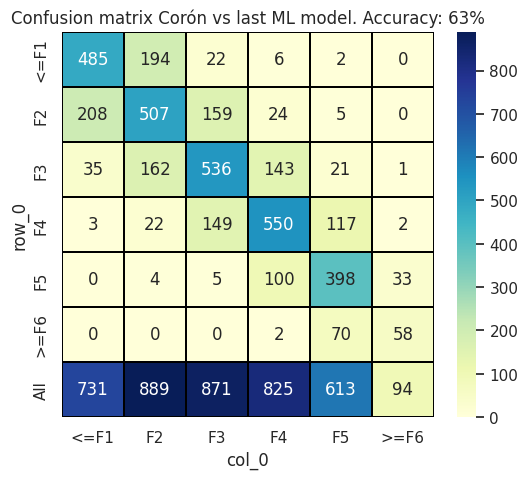

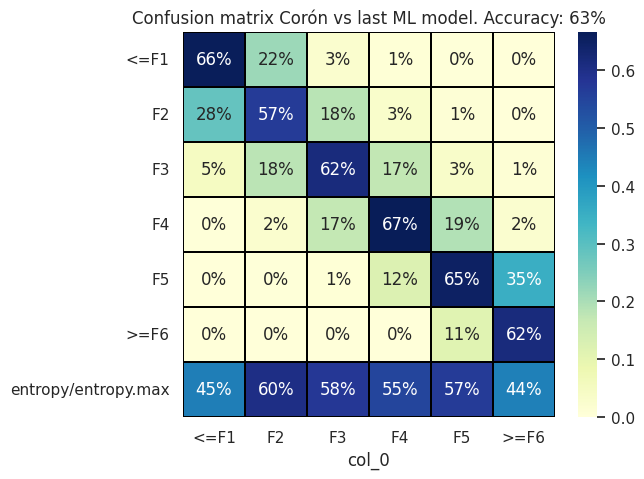

In [ ]:
#@title LGBMClassifier (output variable Cortegada speed at same time). Forecast Corón (day0)

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from lightgbm.sklearn import LGBMClassifier
from sklearn.model_selection import train_test_split

df_global["hour"] = df_global.index.hour
df_global["month"] = df_global.index.month
df_global["dayofyear"] = df_global.index.dayofyear
df_global["weekofyear"] = df_global.index.isocalendar().week.astype(int)

#numpy randomseed
np.random.seed(1)

# target variable Coron
Y = df_global.spd_o_coron_l
X = df_global[["spd_o_corte_l","mod0_d0","dir0_d0","mod1_d0","dir1_d0","mod2_d0","mod3_d0","mod4_d0",
              "wind_gust0_d0","wind_gust1_d0","hour","month",
               "dayofyear","weekofyear"]]

acc_t = []
for t in range (0,10):
  print("machine learning number:",t)
  X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size=0.1, )
  ml_model = LGBMClassifier(n_estimators=200,verbosity=0,).fit(X_train,y_train)
  #ml_model = ExtraTreesClassifier(n_estimators=200).fit(X_train,y_train)
  y_pred = ml_model.predict(X_test)
  acc = round(accuracy_score(y_test,y_pred),2)
  print("Accuracy:",acc )
  acc_t.append(acc)


  # Calculate the total sum of importances
  feature_importances = ml_model.feature_importances_
  total_importance = sum(feature_importances)
  importance_percentages = [(importance / total_importance) * 100 for importance in feature_importances]
  feature_names = X.columns
  feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance (%)': np.round(np.array(importance_percentages),decimals=1)})
  feature_importance_df = feature_importance_df.sort_values(by='Importance (%)', ascending=False)
  display(feature_importance_df[0:5])



print("Accuracy Machine learning models Corón")
df_r=pd.DataFrame({"acc_t":acc_t,});
display(df_r.describe())

#last model Confusion matrix
#raw numbers
plt.figure(figsize=(6, 5))
acc = df_r[-1:].values[0][0]
plt.title("Confusion matrix Corón vs last ML model. Accuracy: {:.0%}".format(acc))
column_sc = pd.crosstab(y_test.values,y_pred , margins=True)[labels]
sns.heatmap(column_sc,annot=True,cmap="YlGnBu",fmt='.0f',linewidths=.3, linecolor='black')

# % numbers
plt.figure(figsize=(6, 5))
acc = df_r[-1:].values[0][0]
plt.title("Confusion matrix Corón vs last ML model. Accuracy: {:.0%}".format(acc))
column_sc = pd.crosstab(y_test.values,y_pred , margins=True,normalize="columns")[labels]
entro = pd.DataFrame(entropy(column_sc,base=2)/(math.log2(column_sc.shape[0])),columns=["entropy/entropy.max"],
                    index=column_sc.columns).T
entropic_sc = pd.concat([column_sc,entro]).rename(columns={"All":"Climatology"})
sns.heatmap(entropic_sc,annot=True,cmap="YlGnBu",fmt='.0%',linewidths=.3, linecolor='black');

machine learning number: 0
Accuracy: 0.55


Feature  Importance (%)
11  dayofyear            12.5
3     dir1_d0             9.8
1     dir0_d0             9.6
9        hour             9.1
4     mod2_d0             8.6

machine learning number: 1
Accuracy: 0.54


Feature  Importance (%)
11  dayofyear            12.9
3     dir1_d0            10.1
1     dir0_d0             9.5
9        hour             9.2
4     mod2_d0             8.5

machine learning number: 2
Accuracy: 0.54


Feature  Importance (%)
11  dayofyear            12.6
3     dir1_d0            10.4
1     dir0_d0             9.7
9        hour             9.2
4     mod2_d0             8.7

machine learning number: 3
Accuracy: 0.54


Feature  Importance (%)
11  dayofyear            12.8
3     dir1_d0            10.6
1     dir0_d0             9.4
9        hour             8.8
4     mod2_d0             8.6

machine learning number: 4
Accuracy: 0.56


Feature  Importance (%)
11  dayofyear            12.8
3     dir1_d0            10.1
1     dir0_d0             9.7
9        hour             9.0
4     mod2_d0             8.6

machine learning number: 5
Accuracy: 0.53


Feature  Importance (%)
11  dayofyear            12.6
1     dir0_d0             9.8
3     dir1_d0             9.8
4     mod2_d0             8.8
9        hour             8.7

machine learning number: 6
Accuracy: 0.55


Feature  Importance (%)
11  dayofyear            12.7
3     dir1_d0            10.5
1     dir0_d0             9.7
9        hour             8.8
4     mod2_d0             8.7

machine learning number: 7
Accuracy: 0.55


Feature  Importance (%)
11  dayofyear            12.8
3     dir1_d0            10.3
1     dir0_d0             9.5
4     mod2_d0             9.2
9        hour             8.7

machine learning number: 8
Accuracy: 0.54


Feature  Importance (%)
11  dayofyear            12.5
3     dir1_d0            10.3
1     dir0_d0             9.4
9        hour             8.8
4     mod2_d0             8.7

machine learning number: 9
Accuracy: 0.54


Feature  Importance (%)
11  dayofyear            12.2
3     dir1_d0            10.6
1     dir0_d0             9.4
9        hour             9.0
4     mod2_d0             8.6

Accuracy Machine learning models Corón


acc_t
count  10.000000
mean    0.544000
std     0.008433
min     0.530000
25%     0.540000
50%     0.540000
75%     0.550000
max     0.560000

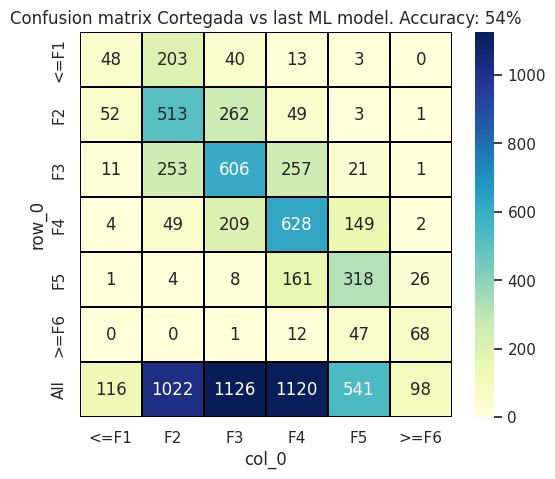

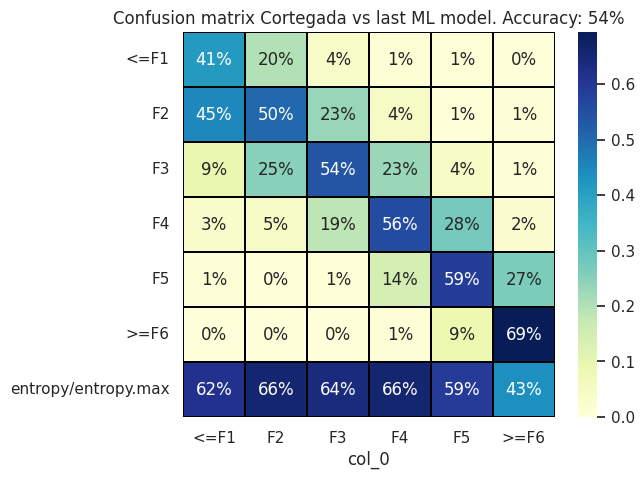

In [ ]:
#@title LGBMClassifier. Forecast Cortegada (day0)

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from lightgbm.sklearn import LGBMClassifier
from sklearn.model_selection import train_test_split

df_global["hour"] = df_global.index.hour
df_global["month"] = df_global.index.month
df_global["dayofyear"] = df_global.index.dayofyear
df_global["weekofyear"] = df_global.index.isocalendar().week.astype(int)

#numpy randomseed
np.random.seed(1)

# target variable Coron
Y = df_global.spd_o_corte_l
X = df_global[["mod0_d0","dir0_d0","mod1_d0","dir1_d0","mod2_d0","mod3_d0","mod4_d0",
              "wind_gust0_d0","wind_gust1_d0","hour","month",
               "dayofyear","weekofyear"]]

acc_t = []
for t in range (0,10):
  print("machine learning number:",t)
  X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size=0.1, )
  ml_model = LGBMClassifier(n_estimators=200,verbosity=0,force_col_wise=True).fit(X_train,y_train)
  #ml_model = ExtraTreesClassifier(n_estimators=200).fit(X_train,y_train)
  y_pred = ml_model.predict(X_test)
  acc = round(accuracy_score(y_test,y_pred),2)
  print("Accuracy:",acc )
  acc_t.append(acc)


  # Calculate the total sum of importances
  feature_importances = ml_model.feature_importances_
  total_importance = sum(feature_importances)
  importance_percentages = [(importance / total_importance) * 100 for importance in feature_importances]
  feature_names = X.columns
  feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance (%)': np.round(np.array(importance_percentages),decimals=1)})
  feature_importance_df = feature_importance_df.sort_values(by='Importance (%)', ascending=False)
  display(feature_importance_df[0:5])



print("Accuracy Machine learning models Corón")
df_r=pd.DataFrame({"acc_t":acc_t,});
display(df_r.describe())

#last model Confusion matrix
#raw numbers
plt.figure(figsize=(6, 5))
acc = df_r[-1:].values[0][0]
plt.title("Confusion matrix Cortegada vs last ML model. Accuracy: {:.0%}".format(acc))
column_sc = pd.crosstab(y_test.values,y_pred , margins=True)[labels]
sns.heatmap(column_sc,annot=True,cmap="YlGnBu",fmt='.0f',linewidths=.3, linecolor='black')

# % numbers
plt.figure(figsize=(6, 5))
acc = df_r[-1:].values[0][0]
plt.title("Confusion matrix Cortegada vs last ML model. Accuracy: {:.0%}".format(acc))
column_sc = pd.crosstab(y_test.values,y_pred , margins=True,normalize="columns")[labels]
entro = pd.DataFrame(entropy(column_sc,base=2)/(math.log2(column_sc.shape[0])),columns=["entropy/entropy.max"],
                    index=column_sc.columns).T
entropic_sc = pd.concat([column_sc,entro]).rename(columns={"All":"Climatology"})
sns.heatmap(entropic_sc,annot=True,cmap="YlGnBu",fmt='.0%',linewidths=.3, linecolor='black');

machine learning number: 0
Accuracy: 0.52


Feature  Importance (%)
11  dayofyear            13.3
3     dir1_d1             9.2
1     dir0_d1             9.1
4     mod2_d1             8.9
6     mod4_d1             8.6

machine learning number: 1
Accuracy: 0.53


Feature  Importance (%)
11  dayofyear            12.8
3     dir1_d1             9.5
1     dir0_d1             9.4
6     mod4_d1             9.1
4     mod2_d1             8.8

machine learning number: 2
Accuracy: 0.53


Feature  Importance (%)
11  dayofyear            13.0
3     dir1_d1             9.6
1     dir0_d1             9.4
6     mod4_d1             8.7
4     mod2_d1             8.5

machine learning number: 3
Accuracy: 0.53


Feature  Importance (%)
11  dayofyear            13.1
3     dir1_d1             9.8
1     dir0_d1             9.2
6     mod4_d1             9.2
4     mod2_d1             8.8

machine learning number: 4
Accuracy: 0.53


Feature  Importance (%)
11  dayofyear            13.5
3     dir1_d1             9.6
1     dir0_d1             9.4
6     mod4_d1             8.8
4     mod2_d1             8.6

machine learning number: 5
Accuracy: 0.53


Feature  Importance (%)
11  dayofyear            13.4
3     dir1_d1             9.9
1     dir0_d1             9.2
6     mod4_d1             8.8
4     mod2_d1             8.5

machine learning number: 6
Accuracy: 0.52


Feature  Importance (%)
11  dayofyear            12.6
3     dir1_d1             9.5
1     dir0_d1             9.2
6     mod4_d1             9.0
4     mod2_d1             8.6

machine learning number: 7
Accuracy: 0.54


Feature  Importance (%)
11  dayofyear            13.0
3     dir1_d1             9.6
1     dir0_d1             9.2
6     mod4_d1             9.0
4     mod2_d1             8.7

machine learning number: 8
Accuracy: 0.52


Feature  Importance (%)
11  dayofyear            13.3
3     dir1_d1             9.7
1     dir0_d1             9.1
6     mod4_d1             9.1
4     mod2_d1             8.7

machine learning number: 9
Accuracy: 0.53


Feature  Importance (%)
11  dayofyear            13.4
3     dir1_d1             9.7
6     mod4_d1             9.2
1     dir0_d1             9.0
4     mod2_d1             8.7

Accuracy Machine learning models Corón


acc_t
count  10.000000
mean    0.528000
std     0.006325
min     0.520000
25%     0.522500
50%     0.530000
75%     0.530000
max     0.540000

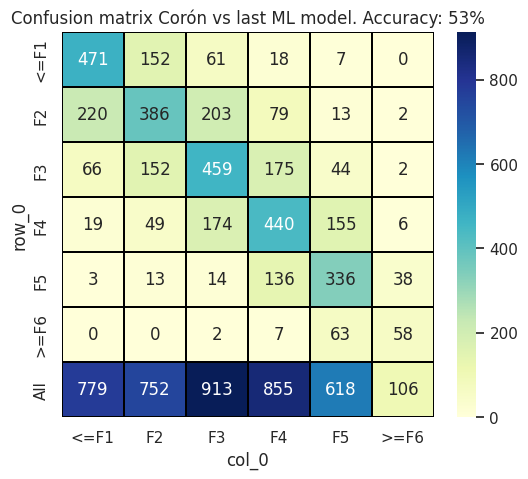

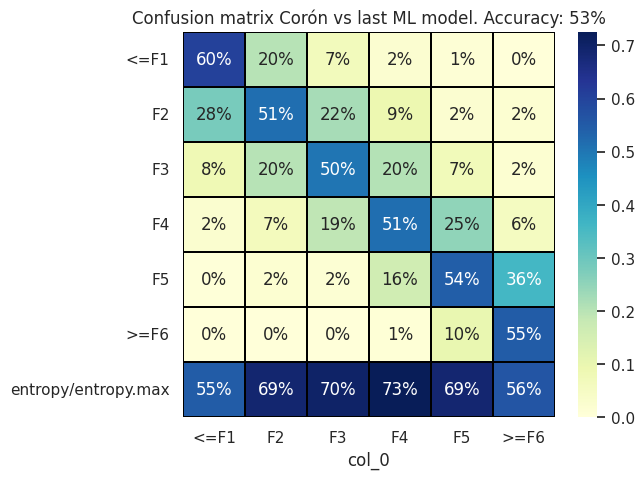

In [ ]:
#@title LGBMClassifier. Forecast Corón (day1)

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from lightgbm.sklearn import LGBMClassifier
from sklearn.model_selection import train_test_split

df_global["hour"] = df_global.index.hour
df_global["month"] = df_global.index.month
df_global["dayofyear"] = df_global.index.dayofyear
df_global["weekofyear"] = df_global.index.isocalendar().week.astype(int)

#numpy randomseed
np.random.seed(1)

# target variable Coron
Y = df_global.spd_o_coron_l
X = df_global[["mod0_d1","dir0_d1","mod1_d1","dir1_d1","mod2_d1","mod3_d1","mod4_d1",
              "wind_gust0_d1","wind_gust1_d1","hour","month",
               "dayofyear","weekofyear"]]

acc_t = []
for t in range (0,10):
  print("machine learning number:",t)
  X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size=0.1, )
  ml_model = LGBMClassifier(n_estimators=200,verbosity=0,force_col_wise=True).fit(X_train,y_train)
  #ml_model = ExtraTreesClassifier(n_estimators=200).fit(X_train,y_train)
  y_pred = ml_model.predict(X_test)
  acc = round(accuracy_score(y_test,y_pred),2)
  print("Accuracy:",acc )
  acc_t.append(acc)


  # Calculate the total sum of importances
  feature_importances = ml_model.feature_importances_
  total_importance = sum(feature_importances)
  importance_percentages = [(importance / total_importance) * 100 for importance in feature_importances]
  feature_names = X.columns
  feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance (%)': np.round(np.array(importance_percentages),decimals=1)})
  feature_importance_df = feature_importance_df.sort_values(by='Importance (%)', ascending=False)
  display(feature_importance_df[0:5])



print("Accuracy Machine learning models Corón")
df_r=pd.DataFrame({"acc_t":acc_t,});
display(df_r.describe())

#last model Confusion matrix
#raw numbers
plt.figure(figsize=(6, 5))
acc = df_r[-1:].values[0][0]
plt.title("Confusion matrix Corón vs last ML model. Accuracy: {:.0%}".format(acc))
column_sc = pd.crosstab(y_test.values,y_pred , margins=True)[labels]
sns.heatmap(column_sc,annot=True,cmap="YlGnBu",fmt='.0f',linewidths=.3, linecolor='black')

# % numbers
plt.figure(figsize=(6, 5))
acc = df_r[-1:].values[0][0]
plt.title("Confusion matrix Corón vs last ML model. Accuracy: {:.0%}".format(acc))
column_sc = pd.crosstab(y_test.values,y_pred , margins=True,normalize="columns")[labels]
entro = pd.DataFrame(entropy(column_sc,base=2)/(math.log2(column_sc.shape[0])),columns=["entropy/entropy.max"],
                    index=column_sc.columns).T
entropic_sc = pd.concat([column_sc,entro]).rename(columns={"All":"Climatology"})
sns.heatmap(entropic_sc,annot=True,cmap="YlGnBu",fmt='.0%',linewidths=.3, linecolor='black');

machine learning number: 0
Accuracy: 0.53


Feature  Importance (%)
11  dayofyear            13.1
3     dir1_d1            10.0
1     dir0_d1             9.4
6     mod4_d1             8.6
4     mod2_d1             8.5

machine learning number: 1
Accuracy: 0.53


Feature  Importance (%)
11  dayofyear            13.1
3     dir1_d1            10.0
1     dir0_d1             9.6
6     mod4_d1             8.8
9        hour             8.4

machine learning number: 2
Accuracy: 0.53


Feature  Importance (%)
11  dayofyear            13.1
3     dir1_d1             9.8
1     dir0_d1             9.6
6     mod4_d1             8.5
4     mod2_d1             8.4

machine learning number: 3
Accuracy: 0.51


Feature  Importance (%)
11  dayofyear            13.1
3     dir1_d1            10.0
1     dir0_d1             9.8
6     mod4_d1             8.7
4     mod2_d1             8.6

machine learning number: 4
Accuracy: 0.53


Feature  Importance (%)
11  dayofyear            12.8
3     dir1_d1             9.9
1     dir0_d1             9.6
4     mod2_d1             8.6
6     mod4_d1             8.4

machine learning number: 5
Accuracy: 0.51


Feature  Importance (%)
11  dayofyear            13.2
3     dir1_d1            10.0
1     dir0_d1             9.7
4     mod2_d1             8.8
6     mod4_d1             8.4

machine learning number: 6
Accuracy: 0.52


Feature  Importance (%)
11  dayofyear            13.1
1     dir0_d1             9.7
3     dir1_d1             9.7
4     mod2_d1             8.7
6     mod4_d1             8.4

machine learning number: 7
Accuracy: 0.52


Feature  Importance (%)
11  dayofyear            13.3
3     dir1_d1             9.9
1     dir0_d1             9.4
4     mod2_d1             8.8
6     mod4_d1             8.7

machine learning number: 8
Accuracy: 0.52


Feature  Importance (%)
11  dayofyear            13.3
1     dir0_d1             9.8
3     dir1_d1             9.7
4     mod2_d1             8.5
9        hour             8.4

machine learning number: 9
Accuracy: 0.52


Feature  Importance (%)
11  dayofyear            13.0
3     dir1_d1            10.1
1     dir0_d1             9.7
6     mod4_d1             8.8
9        hour             8.6

Accuracy Machine learning models Corón


acc_t
count  10.000000
mean    0.522000
std     0.007888
min     0.510000
25%     0.520000
50%     0.520000
75%     0.530000
max     0.530000

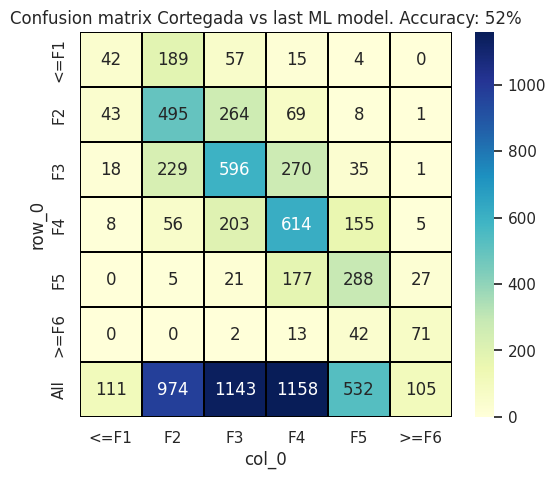

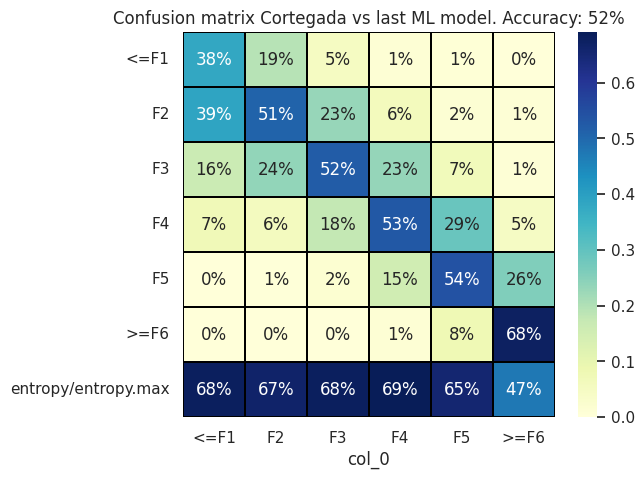

In [ ]:
#@title LGBMClassifier. Forecast Cortegada (day1)

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from lightgbm.sklearn import LGBMClassifier
from sklearn.model_selection import train_test_split

df_global["hour"] = df_global.index.hour
df_global["month"] = df_global.index.month
df_global["dayofyear"] = df_global.index.dayofyear
df_global["weekofyear"] = df_global.index.isocalendar().week.astype(int)

#numpy randomseed
np.random.seed(1)

# target variable Coron
Y = df_global.spd_o_corte_l
X = df_global[["mod0_d1","dir0_d1","mod1_d1","dir1_d1","mod2_d1","mod3_d1","mod4_d1",
              "wind_gust0_d1","wind_gust1_d1","hour","month",
               "dayofyear","weekofyear"]]

acc_t = []
for t in range (0,10):
  print("machine learning number:",t)
  X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size=0.1, )
  ml_model = LGBMClassifier(n_estimators=200,verbosity=0,force_col_wise=True).fit(X_train,y_train)
  #ml_model = ExtraTreesClassifier(n_estimators=200).fit(X_train,y_train)
  y_pred = ml_model.predict(X_test)
  acc = round(accuracy_score(y_test,y_pred),2)
  print("Accuracy:",acc )
  acc_t.append(acc)


  # Calculate the total sum of importances
  feature_importances = ml_model.feature_importances_
  total_importance = sum(feature_importances)
  importance_percentages = [(importance / total_importance) * 100 for importance in feature_importances]
  feature_names = X.columns
  feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance (%)': np.round(np.array(importance_percentages),decimals=1)})
  feature_importance_df = feature_importance_df.sort_values(by='Importance (%)', ascending=False)
  display(feature_importance_df[0:5])



print("Accuracy Machine learning models Corón")
df_r=pd.DataFrame({"acc_t":acc_t,});
display(df_r.describe())

#last model Confusion matrix
#raw numbers
plt.figure(figsize=(6, 5))
acc = df_r[-1:].values[0][0]
plt.title("Confusion matrix Cortegada vs last ML model. Accuracy: {:.0%}".format(acc))
column_sc = pd.crosstab(y_test.values,y_pred , margins=True)[labels]
sns.heatmap(column_sc,annot=True,cmap="YlGnBu",fmt='.0f',linewidths=.3, linecolor='black')

# % numbers
plt.figure(figsize=(6, 5))
acc = df_r[-1:].values[0][0]
plt.title("Confusion matrix Cortegada vs last ML model. Accuracy: {:.0%}".format(acc))
column_sc = pd.crosstab(y_test.values,y_pred , margins=True,normalize="columns")[labels]
entro = pd.DataFrame(entropy(column_sc,base=2)/(math.log2(column_sc.shape[0])),columns=["entropy/entropy.max"],
                    index=column_sc.columns).T
entropic_sc = pd.concat([column_sc,entro]).rename(columns={"All":"Climatology"})
sns.heatmap(entropic_sc,annot=True,cmap="YlGnBu",fmt='.0%',linewidths=.3, linecolor='black');

machine learning number: 0
Accuracy: 0.56


Feature  Importance (%)
4  mod2_d0             9.5
1  dir0_d0             9.3
2  mod1_d0             9.3
3  dir1_d0             9.2
5  mod3_d0             8.6

machine learning number: 1
Accuracy: 0.57


Feature  Importance (%)
4  mod2_d0             9.5
3  dir1_d0             9.4
1  dir0_d0             9.1
2  mod1_d0             9.0
5  mod3_d0             8.9

machine learning number: 2
Accuracy: 0.57


Feature  Importance (%)
4  mod2_d0             9.7
2  mod1_d0             9.6
3  dir1_d0             9.5
1  dir0_d0             9.1
5  mod3_d0             8.6

machine learning number: 3
Accuracy: 0.57


Feature  Importance (%)
4  mod2_d0             9.4
2  mod1_d0             9.3
3  dir1_d0             9.3
1  dir0_d0             9.2
5  mod3_d0             8.8

machine learning number: 4
Accuracy: 0.59


Feature  Importance (%)
4  mod2_d0             9.8
3  dir1_d0             9.6
1  dir0_d0             9.0
5  mod3_d0             9.0
2  mod1_d0             8.8

machine learning number: 5
Accuracy: 0.56


Feature  Importance (%)
4  mod2_d0             9.7
3  dir1_d0             9.5
2  mod1_d0             9.2
1  dir0_d0             9.1
5  mod3_d0             8.8

machine learning number: 6
Accuracy: 0.59


Feature  Importance (%)
2  mod1_d0             9.8
3  dir1_d0             9.5
4  mod2_d0             9.3
1  dir0_d0             9.1
5  mod3_d0             8.5

machine learning number: 7
Accuracy: 0.56


Feature  Importance (%)
4  mod2_d0             9.7
3  dir1_d0             9.3
1  dir0_d0             9.2
2  mod1_d0             9.0
5  mod3_d0             8.5

machine learning number: 8
Accuracy: 0.58


Feature  Importance (%)
2  mod1_d0             9.5
4  mod2_d0             9.5
3  dir1_d0             9.4
1  dir0_d0             9.1
5  mod3_d0             8.5

machine learning number: 9
Accuracy: 0.58


Feature  Importance (%)
4  mod2_d0             9.7
3  dir1_d0             9.5
1  dir0_d0             9.0
5  mod3_d0             8.9
2  mod1_d0             8.7

Accuracy Machine learning models Corón


acc_t
count  10.000000
mean    0.573000
std     0.011595
min     0.560000
25%     0.562500
50%     0.570000
75%     0.580000
max     0.590000

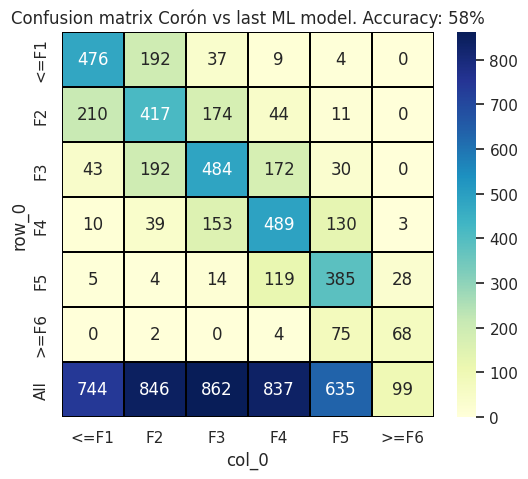

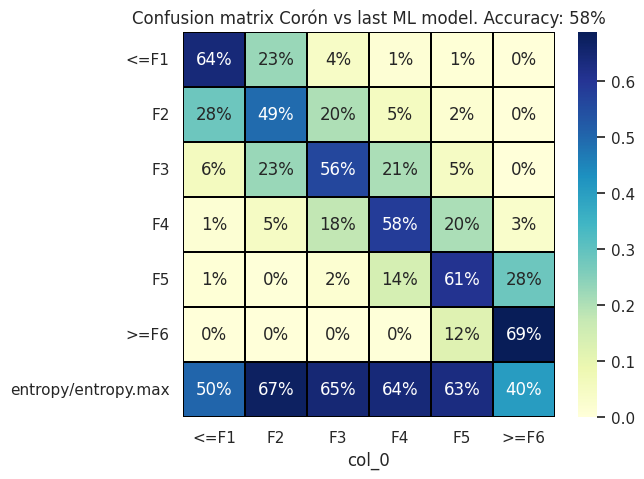

In [ ]:
#@title ExtraTreesClassifier. Forecast Corón (day0)

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from lightgbm.sklearn import LGBMClassifier
from sklearn.model_selection import train_test_split

df_global["hour"] = df_global.index.hour
df_global["month"] = df_global.index.month
df_global["dayofyear"] = df_global.index.dayofyear
df_global["weekofyear"] = df_global.index.isocalendar().week.astype(int)

#numpy randomseed
np.random.seed(1)

# target variable Coron
Y = df_global.spd_o_coron_l
X = df_global[["mod0_d0","dir0_d0","mod1_d0","dir1_d0","mod2_d0","mod3_d0","mod4_d0",
              "wind_gust0_d0","wind_gust1_d0","hour","month",
               "dayofyear","weekofyear"]]

acc_t = []
for t in range (0,10):
  print("machine learning number:",t)
  X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size=0.1, )
  #ml_model = LGBMClassifier(n_estimators=200,verbosity=0,force_col_wise=True).fit(X_train,y_train)
  ml_model = ExtraTreesClassifier(n_estimators=200).fit(X_train,y_train)
  y_pred = ml_model.predict(X_test)
  acc = round(accuracy_score(y_test,y_pred),2)
  print("Accuracy:",acc )
  acc_t.append(acc)


  # Calculate the total sum of importances
  feature_importances = ml_model.feature_importances_
  total_importance = sum(feature_importances)
  importance_percentages = [(importance / total_importance) * 100 for importance in feature_importances]
  feature_names = X.columns
  feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance (%)': np.round(np.array(importance_percentages),decimals=1)})
  feature_importance_df = feature_importance_df.sort_values(by='Importance (%)', ascending=False)
  display(feature_importance_df[0:5])



print("Accuracy Machine learning models Corón")
df_r=pd.DataFrame({"acc_t":acc_t,});
display(df_r.describe())

#last model Confusion matrix
#raw numbers
plt.figure(figsize=(6, 5))
acc = df_r[-1:].values[0][0]
plt.title("Confusion matrix Corón vs last ML model. Accuracy: {:.0%}".format(acc))
column_sc = pd.crosstab(y_test.values,y_pred , margins=True)[labels]
sns.heatmap(column_sc,annot=True,cmap="YlGnBu",fmt='.0f',linewidths=.3, linecolor='black')


# % numbers
plt.figure(figsize=(6, 5))
acc = df_r[-1:].values[0][0]
plt.title("Confusion matrix Corón vs last ML model. Accuracy: {:.0%}".format(acc))
column_sc = pd.crosstab(y_test.values,y_pred , margins=True,normalize="columns")[labels]
entro = pd.DataFrame(entropy(column_sc,base=2)/(math.log2(column_sc.shape[0])),columns=["entropy/entropy.max"],
                    index=column_sc.columns).T
entropic_sc = pd.concat([column_sc,entro]).rename(columns={"All":"Climatology"})
sns.heatmap(entropic_sc,annot=True,cmap="YlGnBu",fmt='.0%',linewidths=.3, linecolor='black');



machine learning number: 0
Accuracy: 0.54


Feature  Importance (%)
4  mod2_d1             9.5
3  dir1_d1             9.2
1  dir0_d1             9.1
2  mod1_d1             9.0
5  mod3_d1             8.5

machine learning number: 1
Accuracy: 0.54


Feature  Importance (%)
3  dir1_d1             9.3
4  mod2_d1             9.2
1  dir0_d1             9.1
2  mod1_d1             8.8
5  mod3_d1             8.8

machine learning number: 2
Accuracy: 0.54


Feature  Importance (%)
3  dir1_d1             9.4
4  mod2_d1             9.3
1  dir0_d1             9.1
2  mod1_d1             9.0
5  mod3_d1             8.6

machine learning number: 3
Accuracy: 0.54


Feature  Importance (%)
4  mod2_d1             9.4
3  dir1_d1             9.3
1  dir0_d1             9.0
2  mod1_d1             8.9
5  mod3_d1             8.5

machine learning number: 4
Accuracy: 0.56


Feature  Importance (%)
4  mod2_d1             9.7
3  dir1_d1             9.4
1  dir0_d1             8.9
5  mod3_d1             8.8
2  mod1_d1             8.7

machine learning number: 5
Accuracy: 0.54


Feature  Importance (%)
4  mod2_d1             9.6
1  dir0_d1             9.2
3  dir1_d1             9.2
2  mod1_d1             8.9
5  mod3_d1             8.5

machine learning number: 6
Accuracy: 0.55


Feature  Importance (%)
3  dir1_d1             9.4
4  mod2_d1             9.4
2  mod1_d1             9.2
1  dir0_d1             9.0
5  mod3_d1             8.5

machine learning number: 7
Accuracy: 0.54


Feature  Importance (%)
4  mod2_d1             9.4
1  dir0_d1             9.2
3  dir1_d1             9.2
2  mod1_d1             8.8
5  mod3_d1             8.4

machine learning number: 8
Accuracy: 0.54


Feature  Importance (%)
4  mod2_d1             9.3
3  dir1_d1             9.2
1  dir0_d1             9.1
2  mod1_d1             8.9
5  mod3_d1             8.7

machine learning number: 9
Accuracy: 0.54


Feature  Importance (%)
4  mod2_d1             9.5
3  dir1_d1             9.4
1  dir0_d1             9.0
5  mod3_d1             8.9
2  mod1_d1             8.7

Accuracy Machine learning models Corón


acc_t
count  10.000000
mean    0.543000
std     0.006749
min     0.540000
25%     0.540000
50%     0.540000
75%     0.540000
max     0.560000

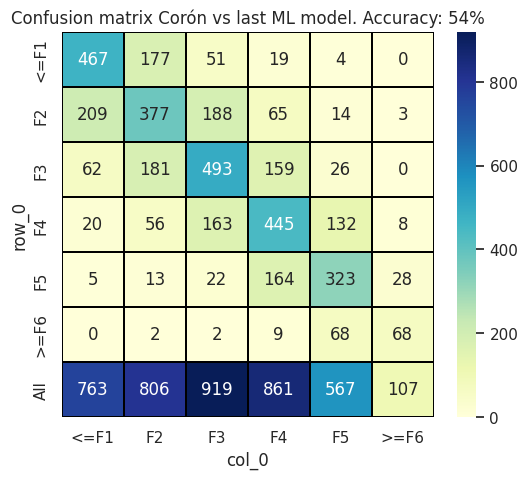

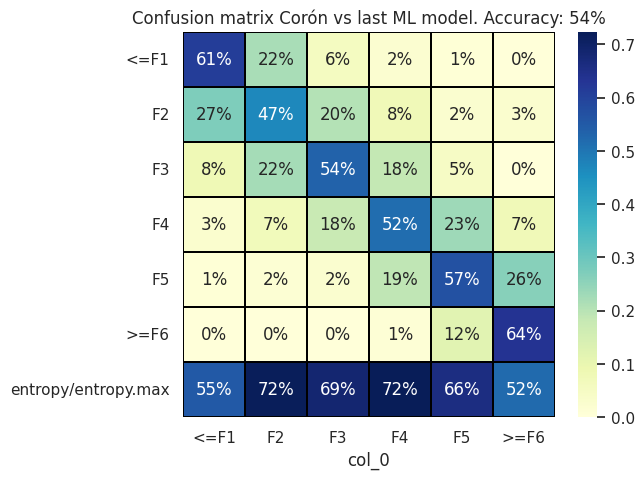

In [ ]:
#@title ExtraTreesClassifier. Forecast Corón (day1)

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from lightgbm.sklearn import LGBMClassifier
from sklearn.model_selection import train_test_split

df_global["hour"] = df_global.index.hour
df_global["month"] = df_global.index.month
df_global["dayofyear"] = df_global.index.dayofyear
df_global["weekofyear"] = df_global.index.isocalendar().week.astype(int)

#numpy randomseed
np.random.seed(1)

# target variable Coron
Y = df_global.spd_o_coron_l
X = df_global[["mod0_d1","dir0_d1","mod1_d1","dir1_d1","mod2_d1","mod3_d1","mod4_d1",
              "wind_gust0_d1","wind_gust1_d1","hour","month",
               "dayofyear","weekofyear"]]

acc_t = []
for t in range (0,10):
  print("machine learning number:",t)
  X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size=0.1, )
  #ml_model = LGBMClassifier(n_estimators=200,verbosity=0,force_col_wise=True).fit(X_train,y_train)
  ml_model = ExtraTreesClassifier(n_estimators=200).fit(X_train,y_train)
  y_pred = ml_model.predict(X_test)
  acc = round(accuracy_score(y_test,y_pred),2)
  print("Accuracy:",acc )
  acc_t.append(acc)


  # Calculate the total sum of importances
  feature_importances = ml_model.feature_importances_
  total_importance = sum(feature_importances)
  importance_percentages = [(importance / total_importance) * 100 for importance in feature_importances]
  feature_names = X.columns
  feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance (%)': np.round(np.array(importance_percentages),decimals=1)})
  feature_importance_df = feature_importance_df.sort_values(by='Importance (%)', ascending=False)
  display(feature_importance_df[0:5])



print("Accuracy Machine learning models Corón")
df_r=pd.DataFrame({"acc_t":acc_t,});
display(df_r.describe())

#last model Confusion matrix
#raw numbers
plt.figure(figsize=(6, 5))
acc = df_r[-1:].values[0][0]
plt.title("Confusion matrix Corón vs last ML model. Accuracy: {:.0%}".format(acc))
column_sc = pd.crosstab(y_test.values,y_pred , margins=True)[labels]
sns.heatmap(column_sc,annot=True,cmap="YlGnBu",fmt='.0f',linewidths=.3, linecolor='black')


# % numbers
plt.figure(figsize=(6, 5))
acc = df_r[-1:].values[0][0]
plt.title("Confusion matrix Corón vs last ML model. Accuracy: {:.0%}".format(acc))
column_sc = pd.crosstab(y_test.values,y_pred , margins=True,normalize="columns")[labels]
entro = pd.DataFrame(entropy(column_sc,base=2)/(math.log2(column_sc.shape[0])),columns=["entropy/entropy.max"],
                    index=column_sc.columns).T
entropic_sc = pd.concat([column_sc,entro]).rename(columns={"All":"Climatology"})
sns.heatmap(entropic_sc,annot=True,cmap="YlGnBu",fmt='.0%',linewidths=.3, linecolor='black');

machine learning number: 0
Accuracy: 0.55


Feature  Importance (%)
4  mod2_d0            11.2
2  mod1_d0            10.3
3  dir1_d0             9.9
1  dir0_d0             9.6
5  mod3_d0             9.4

machine learning number: 1
Accuracy: 0.56


Feature  Importance (%)
4  mod2_d0            11.4
2  mod1_d0             9.9
3  dir1_d0             9.9
1  dir0_d0             9.6
5  mod3_d0             9.6

machine learning number: 2
Accuracy: 0.55


Feature  Importance (%)
4  mod2_d0            11.8
2  mod1_d0            10.3
3  dir1_d0            10.0
1  dir0_d0             9.6
5  mod3_d0             9.0

machine learning number: 3
Accuracy: 0.56


Feature  Importance (%)
4  mod2_d0            11.4
2  mod1_d0            10.2
3  dir1_d0             9.8
1  dir0_d0             9.6
5  mod3_d0             9.6

machine learning number: 4
Accuracy: 0.57


Feature  Importance (%)
4  mod2_d0            11.5
3  dir1_d0            10.1
2  mod1_d0            10.0
5  mod3_d0             9.8
1  dir0_d0             9.4

Accuracy Machine learning models Corón


acc_t
count  5.000000
mean   0.558000
std    0.008367
min    0.550000
25%    0.550000
50%    0.560000
75%    0.560000
max    0.570000

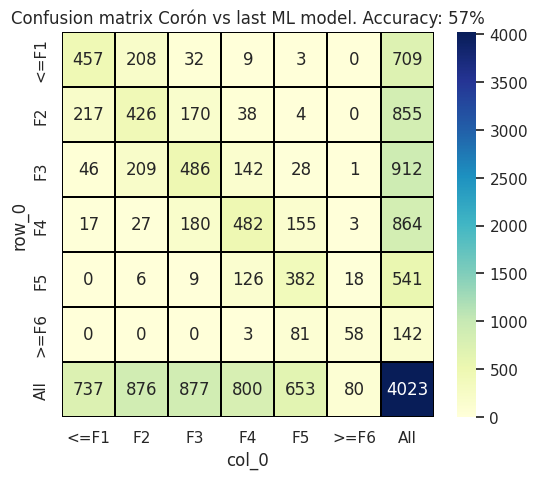

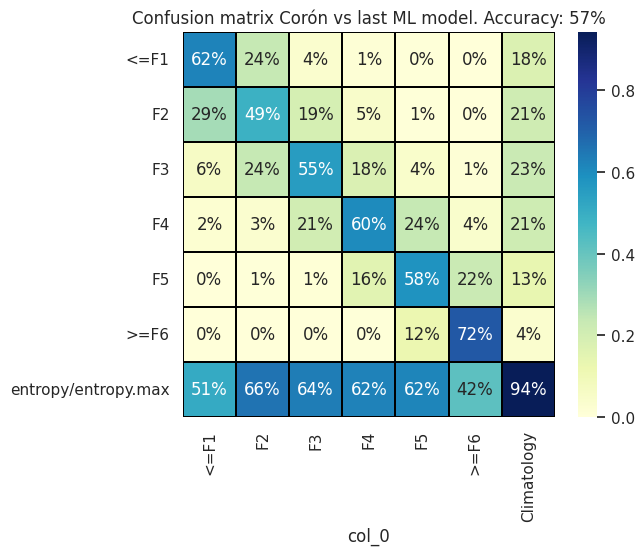

In [ ]:
#@title RandomForestClassifier. Forecast Corón (day0)

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from lightgbm.sklearn import LGBMClassifier
from sklearn.model_selection import train_test_split

df_global["hour"] = df_global.index.hour
df_global["month"] = df_global.index.month
df_global["dayofyear"] = df_global.index.dayofyear
df_global["weekofyear"] = df_global.index.isocalendar().week.astype(int)

#numpy randomseed
np.random.seed(1)

# target variable Coron
Y = df_global.spd_o_coron_l
X = df_global[["mod0_d0","dir0_d0","mod1_d0","dir1_d0","mod2_d0","mod3_d0","mod4_d0",
              "wind_gust0_d0","wind_gust1_d0","hour","month",
               "dayofyear","weekofyear"]]

acc_t = []
for t in range (0,5):
  print("machine learning number:",t)
  X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size=0.1, )
  #ml_model = LGBMClassifier(n_estimators=200,verbosity=0,force_col_wise=True).fit(X_train,y_train)
  ml_model = RandomForestClassifier(n_estimators=200).fit(X_train,y_train)
  y_pred = ml_model.predict(X_test)
  acc = round(accuracy_score(y_test,y_pred),2)
  print("Accuracy:",acc )
  acc_t.append(acc)


  # Calculate the total sum of importances
  feature_importances = ml_model.feature_importances_
  total_importance = sum(feature_importances)
  importance_percentages = [(importance / total_importance) * 100 for importance in feature_importances]
  feature_names = X.columns
  feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance (%)': np.round(np.array(importance_percentages),decimals=1)})
  feature_importance_df = feature_importance_df.sort_values(by='Importance (%)', ascending=False)
  display(feature_importance_df[0:5])



print("Accuracy Machine learning models Corón")
df_r=pd.DataFrame({"acc_t":acc_t,});
display(df_r.describe())

#last model Confusion matrix
#raw numbers
plt.figure(figsize=(6, 5))
acc = df_r[-1:].values[0][0]
plt.title("Confusion matrix Corón vs last ML model. Accuracy: {:.0%}".format(acc))
column_sc = pd.crosstab(y_test.values,y_pred , margins=True)[labels]
sns.heatmap(column_sc,annot=True,cmap="YlGnBu",fmt='.0f',linewidths=.3, linecolor='black')


# % numbers
plt.figure(figsize=(6, 5))
acc = df_r[-1:].values[0][0]
plt.title("Confusion matrix Corón vs last ML model. Accuracy: {:.0%}".format(acc))
column_sc = pd.crosstab(y_test.values,y_pred , margins=True,normalize="columns")[labels]
entro = pd.DataFrame(entropy(column_sc,base=2)/(math.log2(column_sc.shape[0])),columns=["entropy/entropy.max"],
                    index=column_sc.columns).T
entropic_sc = pd.concat([column_sc,entro]).rename(columns={"All":"Climatology"})
sns.heatmap(entropic_sc,annot=True,cmap="YlGnBu",fmt='.0%',linewidths=.3, linecolor='black');
